In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt


from PIL import Image
import os
import glob

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import numpy as np
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [37]:
# network parameters
width = 64
height = 64
latent_dim = 256


# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=(width,height,3), name='encoder_input')

x = Conv2D(32, 3, strides=2, padding='same')(inputs)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Conv2D(128, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

(_,h,w,c) = x.shape

x = Flatten()(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
#encoder.summary()


# # build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(h*w*c, activation='relu')(latent_inputs)
x = Reshape((h,w,c))(x)
x = Conv2D(128,3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(64,3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling2D()(x)
x = Conv2D(32,3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = UpSampling2D()(x)

outputs = Conv2D(3,3, strides=1, activation='sigmoid', padding='same')(x)


# # instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# # instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='cnn_vae')
vae.summary()
history = []

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      [(None, 256)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              2105344   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
batch_normalization_12 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 16, 16, 128)       0   

In [38]:
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= width*height # common practice to scale with w*h
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [36]:
training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.05,
    zoom_range=[.9, .95],
    validation_split=0.95,
    horizontal_flip=False)

training_generator = training_data_generator.flow_from_directory(
   './celeba/',
    target_size=(width, height),
    subset='training',
    batch_size=32,
    class_mode='input')

Found 10130 images belonging to 1 classes.


In [39]:
epochs = 100

history_dict = vae.fit_generator(training_generator, epochs=epochs)
history += history_dict.history['loss']

  ...
    to  
  ['...']
Train for 317 steps
Epoch 1/100
317/317 [==============================] - 28s 90ms/step - loss: 210.7095
Epoch 2/100
317/317 [==============================] - 26s 82ms/step - loss: 143.0711
Epoch 3/100
317/317 [==============================] - 28s 89ms/step - loss: 126.8793
Epoch 4/100
317/317 [==============================] - 27s 86ms/step - loss: 119.5140
Epoch 5/100
317/317 [==============================] - 26s 81ms/step - loss: 115.1181
Epoch 6/100
317/317 [==============================] - 23s 74ms/step - loss: 112.0363 0s - loss: 1
Epoch 7/100
317/317 [==============================] - 24s 77ms/step - loss: 109.4617
Epoch 8/100
317/317 [==============================] - 28s 90ms/step - loss: 108.1329
Epoch 9/100
317/317 [==============================] - 29s 91ms/step - loss: 106.4157
Epoch 10/100
317/317 [==============================] - 27s 84ms/step - loss: 105.0394
Epoch 11/100
317/317 [==============================] - 25s 78ms/step - loss: 104

317/317 [==============================] - 23s 74ms/step - loss: 91.9842
Epoch 95/100
317/317 [==============================] - 20s 62ms/step - loss: 91.9579
Epoch 96/100
317/317 [==============================] - 21s 65ms/step - loss: 91.9835
Epoch 97/100
317/317 [==============================] - 23s 71ms/step - loss: 91.9030
Epoch 98/100
317/317 [==============================] - 22s 70ms/step - loss: 91.8642
Epoch 99/100
317/317 [==============================] - 23s 72ms/step - loss: 91.8899
Epoch 100/100
317/317 [==============================] - 22s 70ms/step - loss: 91.6117


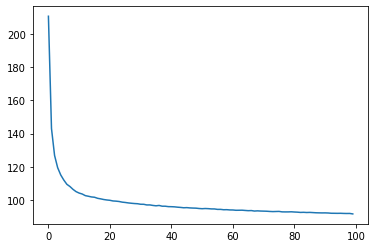

In [41]:
plt.plot(history)

In [ ]:
imgs = training_generator.next()[0]

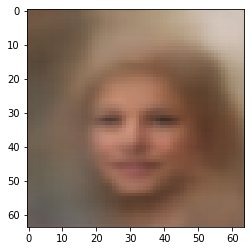

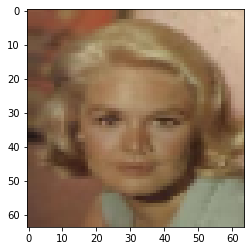

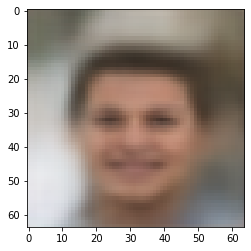

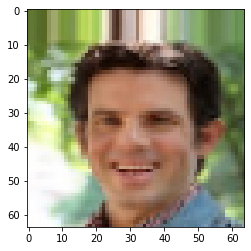

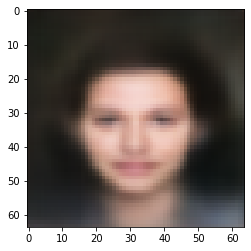

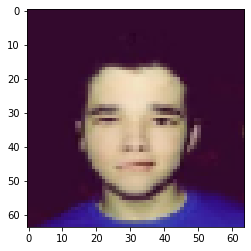

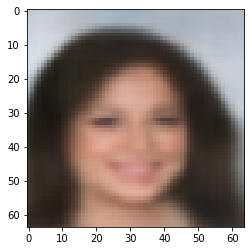

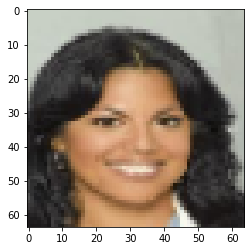

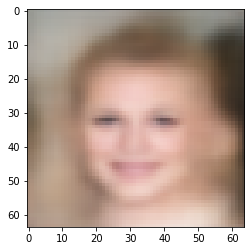

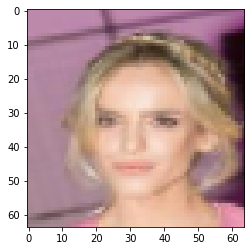

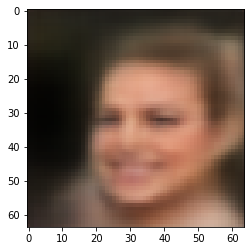

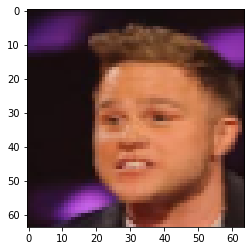

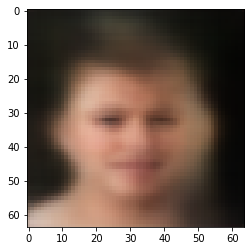

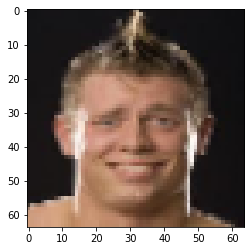

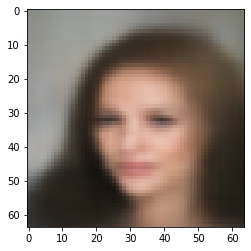

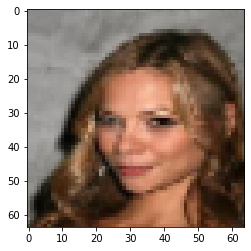

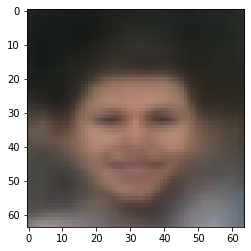

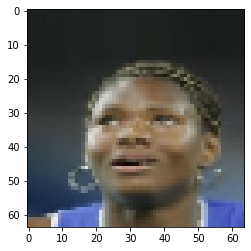

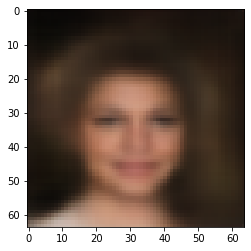

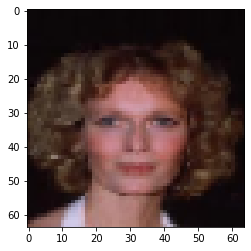

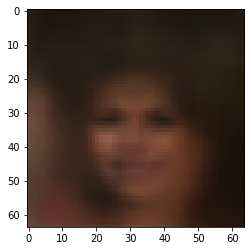

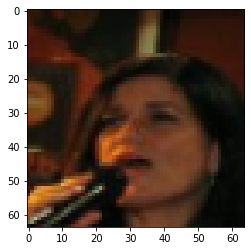

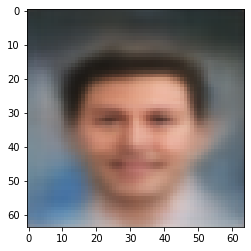

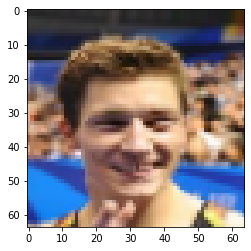

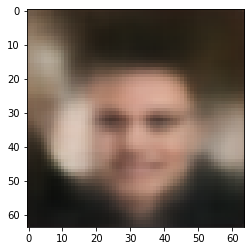

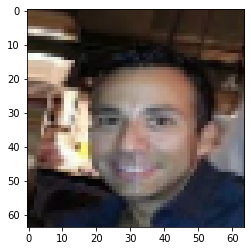

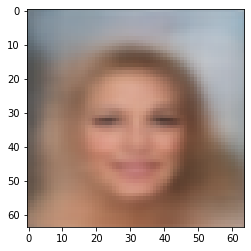

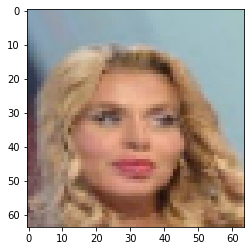

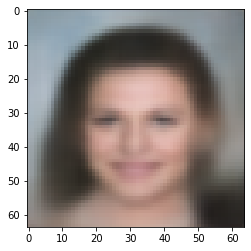

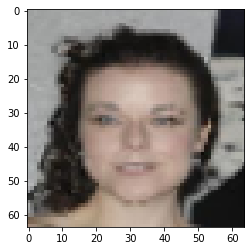

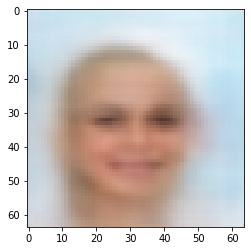

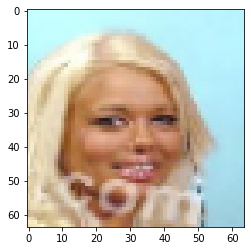

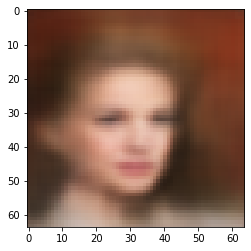

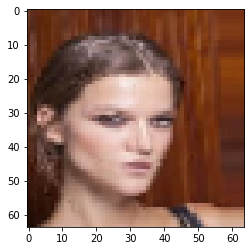

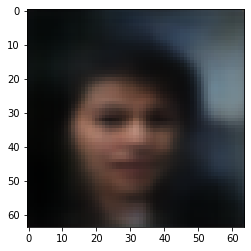

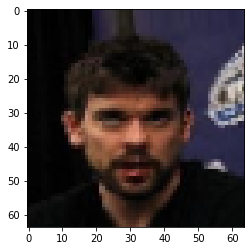

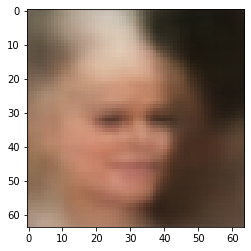

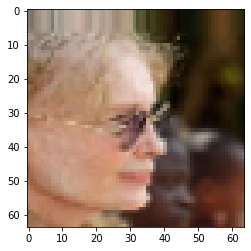

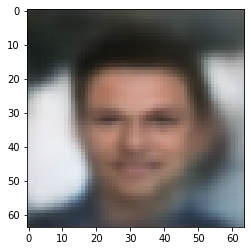

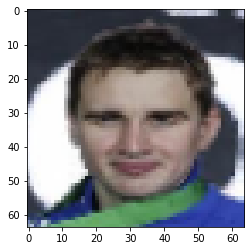

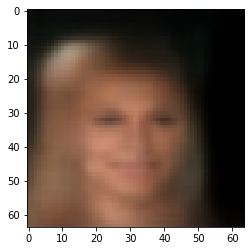

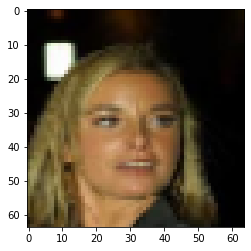

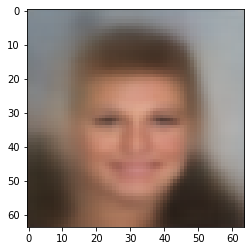

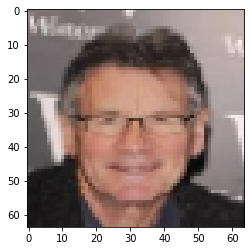

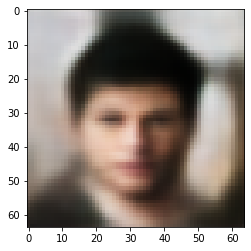

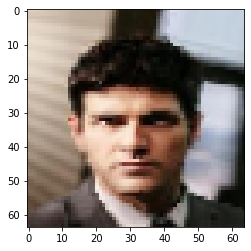

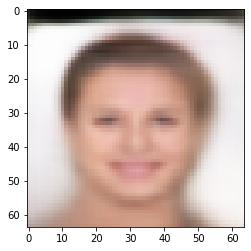

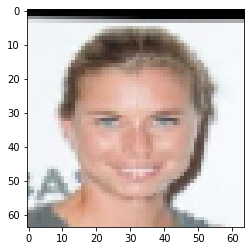

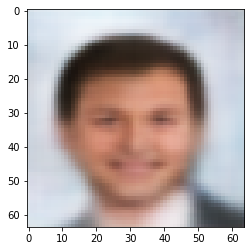

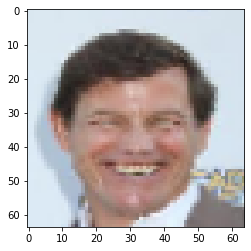

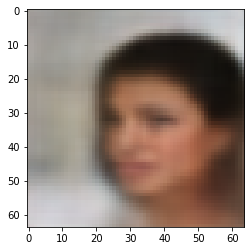

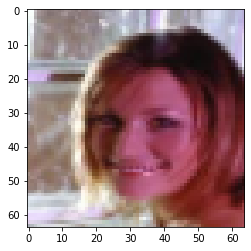

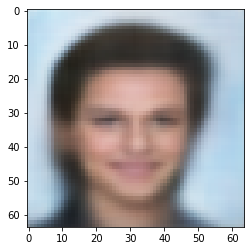

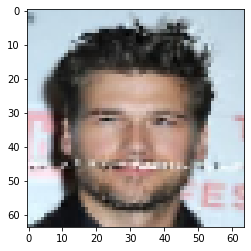

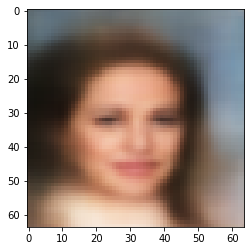

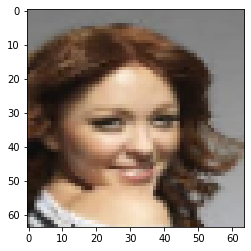

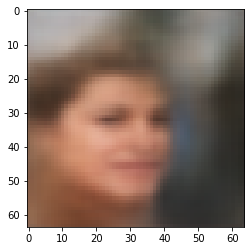

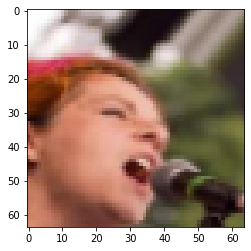

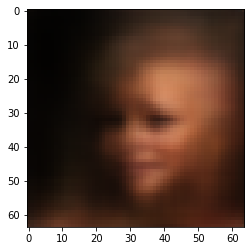

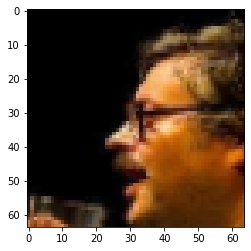

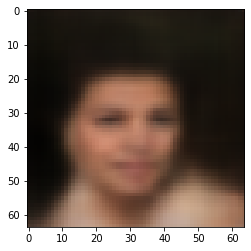

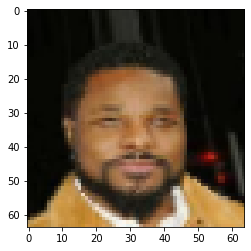

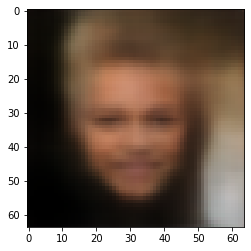

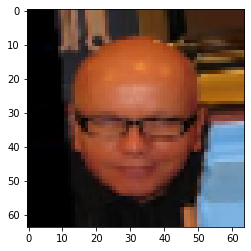

In [71]:
for idx in range(32):
    generated = vae.predict(np.array([imgs[idx]]))[0]
    actual = imgs[idx]

    plt.imshow(generated)
    plt.show()
    plt.imshow(actual)
    plt.show()

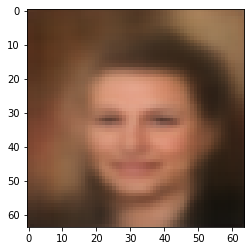

In [72]:
mu, sigma = 0, 1 #mean and standard deviation
s = np.random.normal(mu, sigma, latent_dim)
plt.imshow(decoder.predict(np.array([s]))[0])
plt.show()